## Predicción de temperatura

### Introducción

En este ejercicio se analizarán los datos de temperatura máxima registrados durante los últimos 7 días en la ciudad de Madrid (España) para predecir la temperatura del día siguiente (octavo día).

Para ello, se obtendrán los datos de la API meteorológica `openmeteo` y se realizará un ajuste polinómico por mínimos cuadrados para modelar la tendencia de las temperaturas. Esta técnica consiste en encontrar un polinomio $p(x)$ que minimice el error cuadrático medio respecto a los datos disponibles.

El modelo se ajustará con la función `numpy.polyfit()` y se visualizará junto a los datos originales para evaluar la calidad del ajuste. Finalmente, se evaluará el modelo en el octavo día para obtener una predicción.

Este tipo de análisis tiene aplicaciones prácticas en meteorología, planificación de cultivos y eficiencia energética, donde las estimaciones de temperatura son fundamentales.

### Fundamento matemático

El ajuste polinómico consiste en encontrar un polinomio $p(x)$ de grado $n$ tal que se minimice el error cuadrático:

$$error = \sum_{i=1}^{n} \left( y_i - p(x_i) \right)^2$$


Usamos `numpy.polyfit(x, y, n)` para obtener los coeficientes $a_0, a_1, \dots, a_n$ del polinomio, y `numpy.poly1d()` para construirlo y evaluarlo.

La predicción se obtiene evaluando el modelo en el octavo día:

$$\hat{y}_{n} = p(n)$$


### Desarrollo

Iniciamos importando las librerias que vamos a necesitar para resolver el ejercicio. En este caso:
- **openmeteo y requests**: para obtener datos del tiempo
- **datetime**: manejo de fechas
- **pandas**: para trabajar con los datos en DataFrames
- **numpy**: para realizar el ajuste polinómico de la función
- **matplotlib**: para obtener la gráfica

In [17]:
import openmeteo_requests
import requests, requests_cache
from retry_requests import retry

import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Ahora hacemos la llamada a la API pasando como parámetros la siguiente información:
- latitud y longitud (en este caso de Madrid)
- zona horaria
- dato requerido (humedad, temperaturas, velodidad del viento...)
- fecha inicio
- fecha fin

In [20]:
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 40.4165,
	"longitude": -3.7026,
	"daily": "temperature_2m_max",
	"timezone": "Europe/Berlin",
	"start_date": "2025-09-19",
	"end_date": "2025-09-25"
}
responses = openmeteo.weather_api(url, params=params)

Una vez realizada la llamada a la API, obtenemos la información de la respuesta y la añadimos a un dataframe usando pandas.

In [21]:
# Obtener respuesta (horas)
response = responses[0].Daily()
horario = {"fecha": pd.date_range(
	start = pd.to_datetime(response.Time(), unit = "s", utc = True),
	end = pd.to_datetime(response.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = response.Interval()),
	inclusive = "left"
)}

# Obtener temperaturas por horas
horario["temperatura"] = response.Variables(0).ValuesAsNumpy()

# Crear dataframe
df_tiempo = pd.DataFrame(data = horario)
df_tiempo.head()

,fecha,temperatura
0,2025-09-18 23:00:00+00:00,34.013000
1,2025-09-19 23:00:00+00:00,31.613001
2,2025-09-20 23:00:00+00:00,25.113001
3,2025-09-21 23:00:00+00:00,20.813000
4,2025-09-22 23:00:00+00:00,21.763000


In [22]:
# Crear una nueva columna solo con la fecha 
# se suma 1 porque la fecha de dataframe está en UTC,
# el día 18 a las 22:00 (UTC) pasa a ser día 19 a las 00:00 (hora española)

df_tiempo["dia"] = pd.to_datetime(df_tiempo["fecha"].dt.date + datetime.timedelta(days=1))


In [23]:
df_tiempo

,fecha,temperatura,dia
0,2025-09-18 23:00:00+00:00,34.013000,2025-09-19
1,2025-09-19 23:00:00+00:00,31.613001,2025-09-20
2,2025-09-20 23:00:00+00:00,25.113001,2025-09-21
3,2025-09-21 23:00:00+00:00,20.813000,2025-09-22
4,2025-09-22 23:00:00+00:00,21.763000,2025-09-23
5,2025-09-23 23:00:00+00:00,21.413000,2025-09-24
6,2025-09-24 23:00:00+00:00,23.663000,2025-09-25


Ahora que tenemos las temperaturas máximas y el día correcto, añadimos los datos a un array usando numpy.

In [24]:
# Días del primero al séptimo
x_dias = np.array(df_tiempo['dia'].dt.day)
print(x_dias)

# Temperaturas máximas registradas
y_temp = np.array(df_tiempo['temperatura'].values)
print(y_temp)


[19 20 21 22 23 24 25]
[34.013 31.613 25.113 20.813 21.763 21.413 23.663]


Ahora, se ajusta el polinomio de segundo grado a los datos de días y temperaturas usando `np-polyfit`, que devuelve los coeficientes del polinommio $at^2+bt+c$. Después, `np.poly1d` convierte esos coeficientes en un objeto evaluable como función.

Con el polinomio resultante se calcula la temperatura estimadad para el octavo día.

Se ha seleccionado un polinomio de segundo grado ya que al trabajar con poca cantidad de datos, el modelo cuadrático minimiza el riesgo de sobreajuste en comparación con modelos más complejos.


In [25]:
# Ajuste polinómico de grado 2
grado = 2
coeficientes = np.polyfit(x_dias, y_temp, grado)
polinomio = np.poly1d(coeficientes)

# Predicción para el octavo día
dia_pred = 26
temp_pred = polinomio(dia_pred)

print(f"Predicción de temperatura para el día 26/09: {temp_pred:.2f} °C")


Predicción de temperatura para el día 26/09: 26.87 °C


Por útlimo generamos 200 puntos equiespaciados entre los dias 19 y 26 con `np.linspace` para que el polinomio pueda evaluearse en distintos puntos y trazar una curva suave y sacamos la representación gráfica.

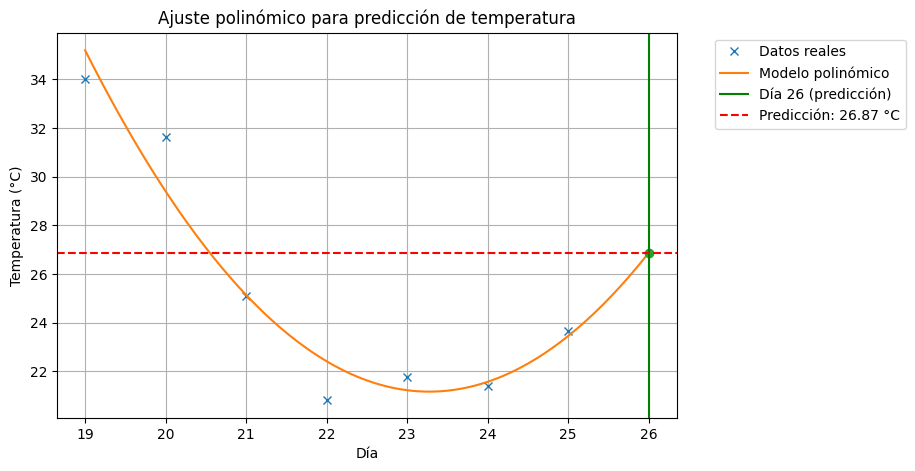

In [26]:
# Puntos para graficar la curva suavemente
x_modelo = np.linspace(19, 26, 200)
y_modelo = polinomio(x_modelo)

# Gráfica
plt.figure(figsize=(8,5))
plt.plot(x_dias, y_temp, 'x', label="Datos reales")
plt.plot(x_modelo, y_modelo, '-', label="Modelo polinómico")
plt.plot(dia_pred, temp_pred, 'o')
plt.axvline(x=dia_pred, color='green', label="Día 26 (predicción)")
plt.axhline(y=temp_pred, linestyle='--', color='red', label=f"Predicción: {temp_pred:.2f} °C")
plt.xlabel("Día")
plt.ylabel("Temperatura (°C)")
plt.title("Ajuste polinómico para predicción de temperatura")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


### Interpretación

La gráfica muestra:
- Puntos azules que representan las temperaturas máximas medidas en cada día (del 19 al 25).
- Curva naranja que representa el ajuste cuadrático que mejor sigue la tendencia creciente de los datos.
- Línea vertical verde en $x = 26$: el día para el que se extrapola la predicción.
- Línea horizontal discontinua roja en $y ≈ 26.87 °C$: la temperatura estimada para el día 26 según el polinomio.

Se ve que el modelo captura bien la forma general de los datos ya que la curva tiene una forma de U suave que aumenta de manera suave a partir del día 23 y entrega para el día 26 una temperatura de 26,87 °C. Algunas mediciones quedan ligeramente por encima o por debajo de la curva, lo cual es normal en un ajuste por mínimos cuadrados. 

En conclusión, vemos que el polinomio de grado 2 ofrece una buena aproximación de la tendencia.